### Basic Imports

In [1]:
import math
import torch
import random
import pandas as pd
import numpy as np
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

### Data Operation

In [2]:
random.seed(0)
class UserItemRatingDataset(Dataset):
    """Wrapper, convert <user, item, rating> Tensor into Pytorch Dataset"""
    def __init__(self, user_tensor, item_tensor, target_tensor):
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.user_tensor.size(0)


class SampleGenerator(object):
    def __init__(self, ratings):
        assert 'userId' in ratings.columns
        assert 'itemId' in ratings.columns
        assert 'rating' in ratings.columns

        self.ratings = ratings
        # explicit feedback using _normalize and implicit using _binarize
        # self.preprocess_ratings = self._normalize(ratings)
        self.preprocess_ratings = self._binarize(ratings)
        self.user_pool = set(self.ratings['userId'].unique())
        self.item_pool = set(self.ratings['itemId'].unique())
        # create negative item samples for NCF learning
        self.negatives = self._sample_negative(ratings)
        self.train_ratings, self.test_ratings = self._split_loo(self.preprocess_ratings)

    def _normalize(self, ratings):
        """normalize into [0, 1] from [0, max_rating], explicit feedback"""
        ratings = deepcopy(ratings)
        max_rating = ratings.rating.max()
        ratings['rating'] = ratings.rating * 1.0 / max_rating
        return ratings
    
    def _binarize(self, ratings):
        """binarize into 0 or 1, imlicit feedback"""
        ratings = deepcopy(ratings)
        ratings['rating'][ratings['rating'] > 0] = 1.0
        return ratings

    def _split_loo(self, ratings):
        """leave one out train/test split """
        ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)
        test = ratings[ratings['rank_latest'] == 1]
        train = ratings[ratings['rank_latest'] > 1]
        assert train['userId'].nunique() == test['userId'].nunique()
        return train[['userId', 'itemId', 'rating']], test[['userId', 'itemId', 'rating']]

    def _sample_negative(self, ratings):
        """return all negative items & 100 sampled negative items"""
        interact_status = ratings.groupby('userId')['itemId'].apply(set).reset_index().rename(
            columns={'itemId': 'interacted_items'})
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
        interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, 99))
        return interact_status[['userId', 'negative_items', 'negative_samples']]

    def instance_a_train_loader(self, num_negatives, batch_size):
        """instance train loader for one training epoch"""
        users, items, ratings = [], [], []
        train_ratings = pd.merge(self.train_ratings, self.negatives[['userId', 'negative_items']], on='userId')
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))
        for row in train_ratings.itertuples():
            users.append(int(row.userId))
            items.append(int(row.itemId))
            ratings.append(float(row.rating))
            for i in range(num_negatives):
                users.append(int(row.userId))
                items.append(int(row.negatives[i]))
                ratings.append(float(0))  # negative samples get 0 rating
        dataset = UserItemRatingDataset(user_tensor=torch.LongTensor(users),
                                        item_tensor=torch.LongTensor(items),
                                        target_tensor=torch.FloatTensor(ratings))
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)
    @property
    def evaluate_data(self):
        """create evaluate data"""
        test_ratings = pd.merge(self.test_ratings, self.negatives[['userId', 'negative_samples']], on='userId')
        test_users, test_items, negative_users, negative_items = [], [], [], []
        for row in test_ratings.itertuples():
            test_users.append(int(row.userId))
            test_items.append(int(row.itemId))
            for i in range(len(row.negative_samples)):
                negative_users.append(int(row.userId))
                negative_items.append(int(row.negative_samples[i]))
        return [torch.LongTensor(test_users), torch.LongTensor(test_items), torch.LongTensor(negative_users),
                torch.LongTensor(negative_items)]

### Utilities

In [3]:
# Checkpoints
def save_checkpoint(model, model_dir):
    torch.save(model.state_dict(), model_dir)


def resume_checkpoint(model, model_dir, device_id):
    state_dict = torch.load(model_dir,
                            map_location=lambda storage, loc: storage.cuda(device=device_id))  # ensure all storage are on gpu
    model.load_state_dict(state_dict)


# Hyper params
def use_cuda(enabled, device_id=0):
    if enabled:
        assert torch.cuda.is_available(), 'CUDA is not available'
        torch.cuda.set_device(device_id)


def use_optimizer(network, params):
    if params['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(network.parameters(),
                                    lr=params['sgd_lr'],
                                    momentum=params['sgd_momentum'],
                                    weight_decay=params['l2_regularization'])
    elif params['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(network.parameters(), 
                                                          lr=params['adam_lr'],
                                                          weight_decay=params['l2_regularization'])
    elif params['optimizer'] == 'rmsprop':
        optimizer = torch.optim.RMSprop(network.parameters(),
                                        lr=params['rmsprop_lr'],
                                        alpha=params['rmsprop_alpha'],
                                        momentum=params['rmsprop_momentum'])
    return optimizer

### Metrics

In [4]:
class MetronAtK(object):
    def __init__(self, top_k):
        self._top_k = top_k
        self._subjects = None  # Subjects which we ran evaluation on

    @property
    def top_k(self):
        return self._top_k

    @top_k.setter
    def top_k(self, top_k):
        self._top_k = top_k

    @property
    def subjects(self):
        return self._subjects

    @subjects.setter
    def subjects(self, subjects):
        """
        args:
            subjects: list, [test_users, test_items, test_scores, negative users, negative items, negative scores]
        """
        assert isinstance(subjects, list)
        test_users, test_items, test_scores = subjects[0], subjects[1], subjects[2]
        neg_users, neg_items, neg_scores = subjects[3], subjects[4], subjects[5]
        # the golden set
        test = pd.DataFrame({'user': test_users,
                             'test_item': test_items,
                             'test_score': test_scores})
        # the full set
        full = pd.DataFrame({'user': neg_users + test_users,
                            'item': neg_items + test_items,
                            'score': neg_scores + test_scores})
        full = pd.merge(full, test, on=['user'], how='left')
        # rank the items according to the scores for each user
        full['rank'] = full.groupby('user')['score'].rank(method='first', ascending=False)
        full.sort_values(['user', 'rank'], inplace=True)
        self._subjects = full

    def cal_hit_ratio(self):
        """Hit Ratio @ top_K"""
        full, top_k = self._subjects, self._top_k
        top_k = full[full['rank']<=top_k]
        test_in_top_k =top_k[top_k['test_item'] == top_k['item']]  # golden items hit in the top_K items
        return len(test_in_top_k) * 1.0 / full['user'].nunique()

    def cal_ndcg(self):
        full, top_k = self._subjects, self._top_k
        top_k = full[full['rank']<=top_k].copy()
        test_in_top_k =top_k[top_k['test_item'] == top_k['item']].copy()
        test_in_top_k.loc[:, 'ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1
        return test_in_top_k['ndcg'].sum() * 1.0 / full['user'].nunique()

### Engine

In [5]:
class Engine(object):
    """Meta Engine for training & evaluating NCF model

    Note: Subclass should implement self.model !
    """

    def __init__(self, config):
        self.config = config  # model configuration
        self._metron = MetronAtK(top_k=10)
        self._writer = SummaryWriter(log_dir='runs/{}'.format(config['alias']))  # tensorboard writer
        self._writer.add_text('config', str(config), 0)
        self.opt = use_optimizer(self.model, config)
        # explicit feedback
        # self.crit = torch.nn.MSELoss()
        # implicit feedback
        self.crit = torch.nn.BCELoss()

    def train_single_batch(self, users, items, ratings):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        if self.config['use_cuda'] is True:
            users, items, ratings = users.cuda(), items.cuda(), ratings.cuda()
        self.opt.zero_grad()
        ratings_pred = self.model(users, items)
        loss = self.crit(ratings_pred.view(-1), ratings)
        loss.backward()
        self.opt.step()
        loss = loss.item()
        return loss

    def train_an_epoch(self, train_loader, epoch_id):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        self.model.train()
        total_loss = 0
        for batch_id, batch in enumerate(train_loader):
            assert isinstance(batch[0], torch.LongTensor)
            user, item, rating = batch[0], batch[1], batch[2]
            rating = rating.float()
            loss = self.train_single_batch(user, item, rating)
            if batch_id % 2500 == 0:
                print('[Training Epoch {}] Batch {}, Loss {}'.format(epoch_id, batch_id, loss))
            total_loss += loss
        self._writer.add_scalar('model/loss', total_loss, epoch_id)
        return loss

    def evaluate(self, evaluate_data, epoch_id):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        self.model.eval()
        with torch.no_grad():
            test_users, test_items = evaluate_data[0], evaluate_data[1]
            negative_users, negative_items = evaluate_data[2], evaluate_data[3]
            if self.config['use_cuda'] is True:
                test_users = test_users.cuda()
                test_items = test_items.cuda()
                negative_users = negative_users.cuda()
                negative_items = negative_items.cuda()
            test_scores = self.model(test_users, test_items)
            negative_scores = self.model(negative_users, negative_items)
            if self.config['use_cuda'] is True:
                test_users = test_users.cpu()
                test_items = test_items.cpu()
                test_scores = test_scores.cpu()
                negative_users = negative_users.cpu()
                negative_items = negative_items.cpu()
                negative_scores = negative_scores.cpu()
            self._metron.subjects = [test_users.data.view(-1).tolist(),
                                 test_items.data.view(-1).tolist(),
                                 test_scores.data.view(-1).tolist(),
                                 negative_users.data.view(-1).tolist(),
                                 negative_items.data.view(-1).tolist(),
                                 negative_scores.data.view(-1).tolist()]
        hit_ratio, ndcg = self._metron.cal_hit_ratio(), self._metron.cal_ndcg()
        self._writer.add_scalar('performance/HR', hit_ratio, epoch_id)
        self._writer.add_scalar('performance/NDCG', ndcg, epoch_id)
        print('[Evluating Epoch {}] HR = {:.4f}, NDCG = {:.4f}'.format(epoch_id, hit_ratio, ndcg))
        return hit_ratio, ndcg

    def save(self, alias, epoch_id, hit_ratio, ndcg):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        model_dir = self.config['model_dir'].format(alias, epoch_id, hit_ratio, ndcg)
        save_checkpoint(self.model, model_dir)

### Import GMF

In [6]:
class GMF(torch.nn.Module):
    def __init__(self, config):
        super(GMF, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.affine_output = torch.nn.Linear(in_features=self.latent_dim, out_features=1)
        self.logistic = torch.nn.Sigmoid()

        # Initialize model parameters with a Gaussian distribution (with a mean of 0 and standard deviation of 0.01)
        if config['weight_init_gaussian']:
            for sm in self.modules():
                if isinstance(sm, (nn.Embedding, nn.Linear)):
                    print(sm)
                    torch.nn.init.normal_(sm.weight.data, 0.0, 0.01)

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

In [7]:
class GMFEngine(Engine):
    """Engine for training & evaluating GMF model"""
    def __init__(self, config):
        self.model = GMF(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(GMFEngine, self).__init__(config)

### Import MLP

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, config):
        super(MLP, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=config['layers'][-1], out_features=1)
        self.logistic = torch.nn.Sigmoid()

        # Initialize model parameters with a Gaussian distribution (with a mean of 0 and standard deviation of 0.01)
        if config['weight_init_gaussian']:
            for sm in self.modules():
                if isinstance(sm, (nn.Embedding, nn.Linear)):
                    print(sm)
                    torch.nn.init.normal_(sm.weight.data, 0.0, 0.01)

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            # vector = torch.nn.BatchNorm1d()(vector)
            # vector = torch.nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

    def load_pretrain_weights(self):
        """Loading weights from trained GMF model"""
        config = self.config
        gmf_model = GMF(config)
        if config['use_cuda'] is True:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mf'], device_id=config['device_id'])
        self.embedding_user.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item.weight.data = gmf_model.embedding_item.weight.data

In [9]:
class MLPEngine(Engine):
    """Engine for training & evaluating GMF model"""
    def __init__(self, config):
        self.model = MLP(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(MLPEngine, self).__init__(config)
        print(self.model)

        if config['pretrain']:
            self.model.load_pretrain_weights()

### Import NMF

In [10]:
class NeuMF(torch.nn.Module):
    def __init__(self, config):
        super(NeuMF, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim_mf = config['latent_dim_mf']
        self.latent_dim_mlp = config['latent_dim_mlp']

        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=config['layers'][-1] + config['latent_dim_mf'], out_features=1)
        self.logistic = torch.nn.Sigmoid()

        # Initialize model parameters with a Gaussian distribution (with a mean of 0 and standard deviation of 0.01)
        if config['weight_init_gaussian']:
            for sm in self.modules():
                if isinstance(sm, (nn.Embedding, nn.Linear)):
                    print(sm)
                    torch.nn.init.normal_(sm.weight.data, 0.0, 0.01)

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

    def load_pretrain_weights(self):
        """Loading weights from trained MLP model & GMF model"""
        config = self.config
        config['latent_dim'] = config['latent_dim_mlp']
        mlp_model = MLP(config)
        if config['use_cuda'] is True:
            mlp_model.cuda()
        resume_checkpoint(mlp_model, model_dir=config['pretrain_mlp'], device_id=config['device_id'])

        self.embedding_user_mlp.weight.data = mlp_model.embedding_user.weight.data
        self.embedding_item_mlp.weight.data = mlp_model.embedding_item.weight.data
        for idx in range(len(self.fc_layers)):
            self.fc_layers[idx].weight.data = mlp_model.fc_layers[idx].weight.data

        config['latent_dim'] = config['latent_dim_mf']
        gmf_model = GMF(config)
        if config['use_cuda'] is True:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mf'], device_id=config['device_id'])
        self.embedding_user_mf.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item_mf.weight.data = gmf_model.embedding_item.weight.data

        self.affine_output.weight.data = 0.5 * torch.cat([mlp_model.affine_output.weight.data, gmf_model.affine_output.weight.data], dim=-1)
        self.affine_output.bias.data = 0.5 * (mlp_model.affine_output.bias.data + gmf_model.affine_output.bias.data)


class NeuMFEngine(Engine):
    """Engine for training & evaluating GMF model"""
    def __init__(self, config):
        self.model = NeuMF(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(NeuMFEngine, self).__init__(config)
        print(self.model)

        if config['pretrain']:
            self.model.load_pretrain_weights()


In [11]:
gmf_config = {'alias': 'gmf_factor8neg4-implict',
              'num_epoch': 20,
              'batch_size': 1024,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'l2_regularization': 0,  # 0.01
              'weight_init_gaussian': True,
              'use_cuda': True,
              'device_id': 0,
              'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}

mlp_config = {'alias': 'mlp_factor8neg4_bz256_166432168_pretrain_reg_0.0000001',
              'num_epoch': 20,
              'batch_size': 256,  # 1024,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'layers': [16, 64, 32, 16, 8], 
              'l2_regularization': 0.0000001,  # MLP model is sensitive to hyper params
              'weight_init_gaussian': True,
              'use_cuda': True,
              'device_id': 0,
              'pretrain': False,
              'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model'),
              'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}

neumf_config = {'alias': 'neumf_factor8neg4',
                'num_epoch': 20,
                'batch_size': 1024,
                'optimizer': 'adam',
                'adam_lr': 1e-3,
                'num_users': 6040,
                'num_items': 3706,
                'latent_dim_mf': 8,
                'latent_dim_mlp': 8,
                'num_negative': 4,
                'layers': [16, 64, 32, 16, 8],  
                'l2_regularization': 0.0000001,
                'weight_init_gaussian': True,
                'use_cuda': True,
                'device_id': 0,
                'pretrain': False,
                'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model'),
                'pretrain_mlp': 'checkpoints/{}'.format('mlp_factor8neg4_Epoch100_HR0.5606_NDCG0.2463.model'),
                'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
                }

In [12]:
# Load Data
ml1m_dir = '/openbayes/input/input0/ratings.dat'
ml1m_rating = pd.read_csv(ml1m_dir, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'], engine='python')
# Reindex
user_id = ml1m_rating[['uid']].drop_duplicates().reindex()
user_id['userId'] = np.arange(len(user_id))
ml1m_rating = pd.merge(ml1m_rating, user_id, on=['uid'], how='left')
item_id = ml1m_rating[['mid']].drop_duplicates()
item_id['itemId'] = np.arange(len(item_id))
ml1m_rating = pd.merge(ml1m_rating, item_id, on=['mid'], how='left')
ml1m_rating = ml1m_rating[['userId', 'itemId', 'rating', 'timestamp']]
print('Range of userId is [{}, {}]'.format(ml1m_rating.userId.min(), ml1m_rating.userId.max()))
print('Range of itemId is [{}, {}]'.format(ml1m_rating.itemId.min(), ml1m_rating.itemId.max()))
# DataLoader for training
sample_generator = SampleGenerator(ratings=ml1m_rating)
evaluate_data = sample_generator.evaluate_data

Range of userId is [0, 6039]
Range of itemId is [0, 3705]


### Specify the exact model

In [13]:
epochs = range(20)

In [14]:
config = gmf_config
engine = GMFEngine(config)
GMF_Model = {'hit_ratio': [], 'ndcg': [], 'training_loss': []}
for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    last_batch_loss = engine.train_an_epoch(train_loader, epoch_id=epoch)
    
    # Evaluate the model after each epoch
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    GMF_Model['hit_ratio'].append(hit_ratio)
    GMF_Model['ndcg'].append(ndcg)
    GMF_Model['training_loss'].append(last_batch_loss)
    # Print the evaluation metrics
    print('After epoch {}:'.format(epoch))
    print('Hit Ratio: {:.4f}'.format(hit_ratio))
    print('NDCG: {:.4f}'.format(ndcg))
    print('Training Loss: {:.4f}'.format(last_batch_loss))
    print('-' * 80)                                
    
    # Save the model after each epoch
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

Embedding(6040, 8)
Embedding(3706, 8)
Linear(in_features=8, out_features=1, bias=True)
Epoch 0 starts !
--------------------------------------------------------------------------------
[Training Epoch 0] Batch 0, Loss 0.7182995080947876
[Training Epoch 0] Batch 2500, Loss 0.3785736560821533
[Evluating Epoch 0] HR = 0.4502, NDCG = 0.2522
After epoch 0:
Hit Ratio: 0.4502
NDCG: 0.2522
Training Loss: 0.3709
--------------------------------------------------------------------------------
Epoch 1 starts !
--------------------------------------------------------------------------------
[Training Epoch 1] Batch 0, Loss 0.31364208459854126
[Training Epoch 1] Batch 2500, Loss 0.34285491704940796
[Evluating Epoch 1] HR = 0.4925, NDCG = 0.2713
After epoch 1:
Hit Ratio: 0.4925
NDCG: 0.2713
Training Loss: 0.3233
--------------------------------------------------------------------------------
Epoch 2 starts !
--------------------------------------------------------------------------------
[Training E

In [15]:
config = mlp_config
engine = MLPEngine(config)
MLP_Model = {'hit_ratio': [], 'ndcg': [], 'training_loss': []}
for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    last_batch_loss = engine.train_an_epoch(train_loader, epoch_id=epoch)
    
    # Evaluate the model after each epoch
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    MLP_Model['hit_ratio'].append(hit_ratio)
    MLP_Model['ndcg'].append(ndcg)
    MLP_Model['training_loss'].append(last_batch_loss)    
    # Print the evaluation metrics
    print('After epoch {}:'.format(epoch))
    print('Hit Ratio: {:.4f}'.format(hit_ratio))
    print('NDCG: {:.4f}'.format(ndcg))
    print('Training Loss: {:.4f}'.format(last_batch_loss))
    print('-' * 80)                                
    # Save the model after each epoch
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

Embedding(6040, 8)
Embedding(3706, 8)
Linear(in_features=16, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=8, bias=True)
Linear(in_features=8, out_features=1, bias=True)
MLP(
  (embedding_user): Embedding(6040, 8)
  (embedding_item): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
--------------------------------------------------------------------------------
[Training Epoch 0] Batch 0, Loss 0.637165904045105
[Training Epoch 0] Batch 2500, Loss 0.4043534994125366
[Training Epoch 0] Batch 5000, Loss 0.3332201838493347
[Tra

In [16]:
config = neumf_config
engine = NeuMFEngine(config)
NeuMF_Model = {'hit_ratio': [], 'ndcg': [], 'training_loss': []}
for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    last_batch_loss = engine.train_an_epoch(train_loader, epoch_id=epoch)
    
    # Evaluate the model after each epoch
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    NeuMF_Model['hit_ratio'].append(hit_ratio)
    NeuMF_Model['ndcg'].append(ndcg)
    NeuMF_Model['training_loss'].append(last_batch_loss)
    # Print the evaluation metrics
    print('After epoch {}:'.format(epoch))
    print('Hit Ratio: {:.4f}'.format(hit_ratio))
    print('NDCG: {:.4f}'.format(ndcg))
    print('Training Loss: {:.4f}'.format(last_batch_loss))
    print('-' * 80)                                
    
    # Save the model after each epoch
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

Embedding(6040, 8)
Embedding(3706, 8)
Embedding(6040, 8)
Embedding(3706, 8)
Linear(in_features=16, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=8, bias=True)
Linear(in_features=16, out_features=1, bias=True)
NeuMF(
  (embedding_user_mlp): Embedding(6040, 8)
  (embedding_item_mlp): Embedding(3706, 8)
  (embedding_user_mf): Embedding(6040, 8)
  (embedding_item_mf): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=16, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
--------------------------------------------------------------------------------
[Training Epoch 0] Batch 0, Los

In [17]:
df_NeuMF = pd.DataFrame(NeuMF_Model)
df_GMF = pd.DataFrame(GMF_Model)
df_MLP = pd.DataFrame(MLP_Model)

# Loop to save dataframes to CSV files with different names
df_NeuMF.to_csv('NeuMF_Model.csv', index=False)
df_GMF.to_csv('GMF_Model.csv', index=False)
df_MLP.to_csv('MLP_Model.csv', index=False)

#### 绘图

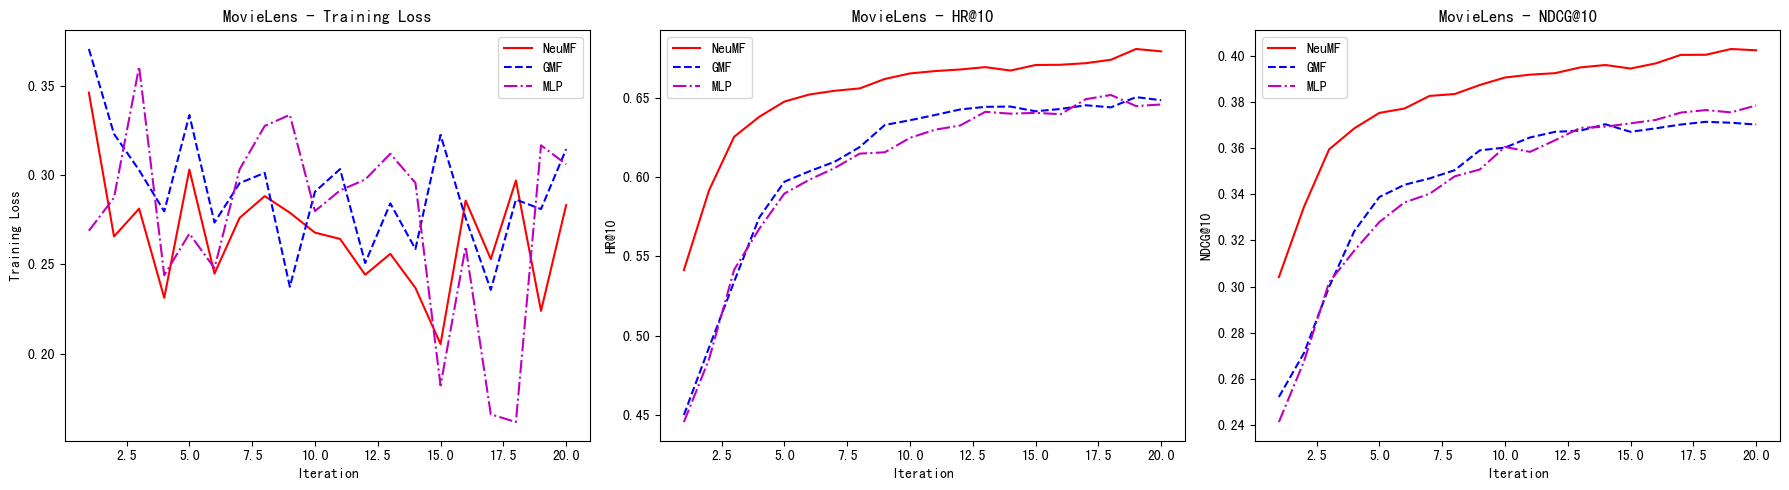

In [18]:
iterations = list(range(1, 21))

plt.figure(figsize=(18, 5))

# Plot Training Loss
plt.subplot(1, 3, 1)
plt.plot(iterations, NeuMF_Model['training_loss'], 'r-', label='NeuMF')
plt.plot(iterations, GMF_Model['training_loss'], 'b--', label='GMF')
plt.plot(iterations, MLP_Model['training_loss'], 'm-.', label='MLP')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('MovieLens - Training Loss')
plt.legend()

# Plot HR@10 over iterations
plt.subplot(1, 3, 2)
plt.plot(iterations, NeuMF_Model['hit_ratio'], 'r-', label='NeuMF')
plt.plot(iterations, GMF_Model['hit_ratio'], 'b--', label='GMF')
plt.plot(iterations, MLP_Model['hit_ratio'], 'm-.', label='MLP')
plt.xlabel('Iteration')
plt.ylabel('HR@10')
plt.title('MovieLens - HR@10')
plt.legend()

# Plot NDCG@10 over iterations
plt.subplot(1, 3, 3)
plt.plot(iterations, NeuMF_Model['ndcg'], 'r-', label='NeuMF')
plt.plot(iterations, GMF_Model['ndcg'], 'b--', label='GMF')
plt.plot(iterations, MLP_Model['ndcg'], 'm-.', label='MLP')
plt.xlabel('Iteration')
plt.ylabel('NDCG@10')
plt.title('MovieLens - NDCG@10')
plt.legend()

plt.tight_layout()
plt.show()

### ablation study

In [20]:
layer_configs = [
    [16, 64, 32, 16, 8],     # 原始配置
    [16, 32, 16, 8],         # 四层网络
    [16, 16, 8],        
    [16,8]     
]

results = []
config = mlp_config
for layers in layer_configs:
    print(f"训练配置层: {layers}")
    config['layers'] = layers
    # 使用新配置初始化引擎
    engine = MLPEngine(config)

    # 训练模型指定的轮数
    for epoch in range(mlp_config['num_epoch']):
        print('Epoch {} starts !'.format(epoch))
        print('-' * 80)
        train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
        engine.train_an_epoch(train_loader, epoch_id=epoch)
        hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
        print(f"轮数 {epoch}: HR = {hit_ratio}, NDCG = {ndcg}")
        engine.save(config['alias'], epoch, hit_ratio, ndcg)
    # 保存该配置的结果
    results.append({
        'layers': layers,
        'HR': hit_ratio,
        'NDCG': ndcg
    })

# 打印最终结果
for result in results:
    print(f"层配置: {result['layers']}, HR: {result['HR']:.4f}, NDCG: {result['NDCG']:.4f}")

训练配置层: [16, 64, 32, 16, 8]
Embedding(6040, 8)
Embedding(3706, 8)
Linear(in_features=16, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=8, bias=True)
Linear(in_features=8, out_features=1, bias=True)
MLP(
  (embedding_user): Embedding(6040, 8)
  (embedding_item): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
--------------------------------------------------------------------------------
[Training Epoch 0] Batch 0, Loss 0.7926473617553711
[Training Epoch 0] Batch 2500, Loss 0.3280324339866638
[Training Epoch 0] Batch 5000, 

### num_negatives

In [ ]:
GMF_negatives_hr = []
MLP_negatives_hr = []
NeuMF_negatives_hr = []
GMF_negatives_ndcg = []
MLP_negatives_ndcg = []
NeuMF_negatives_ndcg = []
for i in range(1,11):
    print('+' * 80)
    print('number of negatives: {}'.format(i))
    if i == 4:
        continue
    config = gmf_config
    engine = GMFEngine(config)
    for epoch in range(config['num_epoch']):
        print('Epoch {} starts !'.format(epoch))
        print('-' * 80)
        train_loader = sample_generator.instance_a_train_loader(i, config['batch_size'])
        last_batch_loss = engine.train_an_epoch(train_loader, epoch_id=epoch)
    
        # Evaluate the model after each epoch
        hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
        print('Hit Ratio: {:.4f}'.format(hit_ratio))
        print('NDCG: {:.4f}'.format(ndcg))
        print('-' * 80)                                
        # Save the model after each epoch
        engine.save(config['alias'], epoch, hit_ratio, ndcg)
    GMF_negatives_hr.append(hit_ratio)
    GMF_negatives_ndcg.append(ndcg)
    config = mlp_config
    engine = MLPEngine(config)
    for epoch in range(config['num_epoch']):
        print('Epoch {} starts !'.format(epoch))
        print('-' * 80)
        train_loader = sample_generator.instance_a_train_loader(i, config['batch_size'])
        last_batch_loss = engine.train_an_epoch(train_loader, epoch_id=epoch)
    
        # Evaluate the model after each epoch
        hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
        print('Hit Ratio: {:.4f}'.format(hit_ratio))
        print('-' * 80)                                
        # Save the model after each epoch
        engine.save(config['alias'], epoch, hit_ratio, ndcg)
    MLP_negatives_hr.append(hit_ratio)
    MLP_negatives_ndcg.append(ndcg)
    config = neumf_config
    engine = NeuMFEngine(config)
    for epoch in range(config['num_epoch']):
        print('Epoch {} starts !'.format(epoch))
        print('-' * 80)
        train_loader = sample_generator.instance_a_train_loader(i, config['batch_size'])
        last_batch_loss = engine.train_an_epoch(train_loader, epoch_id=epoch)
    
        # Evaluate the model after each epoch
        hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
        print('Hit Ratio: {:.4f}'.format(hit_ratio))
        print('-' * 80)                                
        # Save the model after each epoch
        engine.save(config['alias'], epoch, hit_ratio, ndcg)
    NeuMF_negatives_hr.append(hit_ratio)
    NeuMF_negatives_ndcg.append(ndcg)
    


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
number of negatives: 1
Embedding(6040, 8)
Embedding(3706, 8)
Linear(in_features=8, out_features=1, bias=True)
Epoch 0 starts !
--------------------------------------------------------------------------------
[Training Epoch 0] Batch 0, Loss 0.6935431957244873
[Evluating Epoch 0] HR = 0.4596, NDCG = 0.2543
Hit Ratio: 0.4596
NDCG: 0.2543
--------------------------------------------------------------------------------
Epoch 1 starts !
--------------------------------------------------------------------------------
[Training Epoch 1] Batch 0, Loss 0.455078661441803
[Evluating Epoch 1] HR = 0.4856, NDCG = 0.2698
Hit Ratio: 0.4856
NDCG: 0.2698
--------------------------------------------------------------------------------
Epoch 2 starts !
--------------------------------------------------------------------------------
[Training Epoch 2] Batch 0, Loss 0.4544658064842224
[Evluating Epoch 2] HR = 0.4947, NDCG = 0.

In [ ]:
# Create a dictionary with the data
data = {
    'Negatives': list(range(1, 11)),
    'GMF_HR@10': GMF_negatives_hr,
    'MLP_HR@10': MLP_negatives_hr,
    'NeuMF_HR@10': NeuMF_negatives_hr,
    'GMF_NDCG@10': GMF_negatives_ndcg,
    'MLP_NDCG@10': MLP_negatives_ndcg,
    'NeuMF_NDCG@10': NeuMF_negatives_ndcg
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('./negatives_analysis.csv', index=False)

#### 关于负样本绘图

In [ ]:
negatives = np.arange(1, 11)

plt.figure(figsize=(14, 6))

# HR@10 plot
plt.subplot(1, 2, 1)
plt.plot(negatives, NeuMF_negatives_hr, 'r-d', label='NeuMF')
plt.plot(negatives, GMF_negatives_hr, 'b-o', label='GMF')
plt.plot(negatives, MLP_negatives_hr, 'm-x', label='MLP')
plt.axhline(y=0.65, color='y', linestyle='-', label='BPR')
plt.xlabel('Number of Negatives')
plt.ylabel('HR@10')
plt.title('MovieLens')
plt.legend()
plt.grid(True)

# NDCG@10 plot
plt.subplot(1, 2, 2)
plt.plot(negatives, NeuMF_negatives_ndcg, 'r-d', label='NeuMF')
plt.plot(negatives, GMF_negatives_ndcg, 'b-o', label='GMF')
plt.plot(negatives, MLP_negatives_ndcg, 'm-x', label='MLP')
plt.axhline(y=0.36, color='y', linestyle='-', label='BPR')
plt.xlabel('Number of Negatives')
plt.ylabel('NDCG@10')
plt.title('MovieLens')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()